# Credit Card Fraud Detection

## The Data   

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.   
Can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud

## The goal of the Project

For this project, we'll use everything we've learned about Data Science and Machine Learning thus far to source a dataset, preprocess and explore it, and then build and interpret a classification model that answers your chosen question.

Our goal is to predict if a transaction was fraudulent or not.

In [1]:
# basic libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# display options
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# date
from datetime import datetime 

# visualizations libraries
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# ML libraries
import itertools
from collections import Counter
from sklearn.datasets import make_classification
from numpy import where

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('creditcard.csv')

## Preview the data

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

#### Check for NaN values

In [6]:
df.isna().any().any()

False

In [7]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

## Examine imbalance of the data

In [10]:
print('Raw counts: \n')
print(df['Class'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(df['Class'].value_counts(normalize=True))

Raw counts: 

0    284315
1       492
Name: Class, dtype: int64
-----------------------------------
Normalized counts: 

0    0.998273
1    0.001727
Name: Class, dtype: float64


It means we have a dataset with 1 to 1000 class distribution, meaning that we have 284 315 zeros to 492 ones, or 99.87 percent for class 0 and about 0.12 percent for class 1.

### Visualizing our data

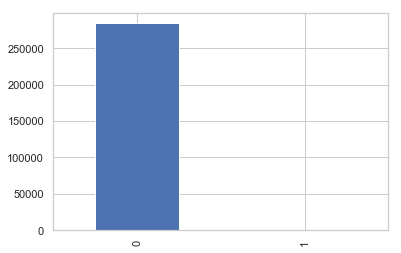

In [11]:
df['Class'].value_counts().plot.bar()

In [12]:
# define target and features
y = df['Class']
X = df.drop(columns=['Class'], axis=1)

X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=3)

Counter({0: 990, 1: 10})


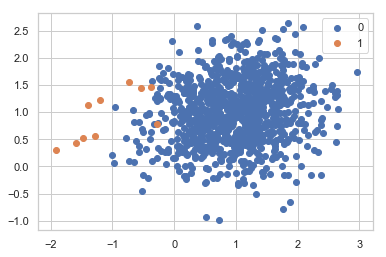

In [13]:
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

For a better understanding of our data let's have a better look at our fraud and non fraud transactions:

In [17]:
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

It looks like in average the amount fraud transactians was higher than the non fraudulent transactions

In [ ]:
# df.hist(figsize=(20,20))
# plt.show()

### Transactions in time

In [ ]:
fraud = df[df['Class']==1]['Time']
non_fraud = df[df['Class']==0]['Time']

hist_df = [fraud, non_fraud]
group_labels = ['Fraud', 'Not Fraud']

fig = ff.create_distplot(hist_df, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions by Time', xaxis=dict(title='Time[s]'))
iplot(fig, filename='dist_only')

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins, color='blue')
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins, color='orange')
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

### Split to train and test sets (not normalised data)

In [18]:
y = df['Class']
X = df.drop(columns=['Class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [19]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    213233
1       372
Name: Class, dtype: int64


0    71082
1      120
Name: Class, dtype: int64


### Create a baseline (non normalised data)

For a baseline model do a Logistic Regression model

In [20]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.8841412031175262


In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()]

In [ ]:
# Logging for Visual Comparison
log_cols=['Classifier', 'Accuracy', 'Log Loss', 'Recall', 'Precision', 'F1']
log = pd.DataFrame(columns=log_cols)

In [ ]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print('='*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print('Accuracy: {:.4%}'.format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print('Log Loss: {}'.format(ll))
    
    train_predictions = clf.predict(X_test)
    rec = recall_score(y_test, train_predictions)
    print('Accuracy: {:.4%}'.format(rec))
    
    train_predictions = clf.predict(X_test)
    pre = precision_score(y_test, train_predictions)
    print('Accuracy: {:.4%}'.format(pre))
    
    train_predictions = clf.predict(X_test)
    f1 = f1_score(y_test, train_predictions)
    print('Accuracy: {:.4%}'.format(f1))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print('='*30)

## Normalise X

We normalise after splitting our data into training and test sets. This is to avoid information "leaking" from our test set into our training set (read more about data leakage here ). Remember that normalisation (also sometimes called Standardization or Scaling) means making sure that all of your data is represented at the same scale. The most common way to do this is to convert all numerical values to z-scores.

In [ ]:
# y = df['Class']
# X = df.drop(columns=['Class'], axis=1)

In [ ]:
# # standardize the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2, shuffle = True, stratify = y)

In [ ]:
# # Convert into a DataFrame
# scaled_df_train = pd.DataFrame(X_train)
# scaled_df_train.head()

## KNN for Scaled data

In [24]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train)
scaled_df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.756654,1.042720,0.066574,-1.190515,0.050609,0.182354,-1.313993,0.581331,-0.402579,-0.093192,0.164812,1.600366,1.180286,-0.242734,1.087642,-0.359350,-0.768636,-0.288819,-0.395361,0.137740,-0.340558,0.324847,1.130270,0.037162,0.907244,0.617550,0.399050,-0.210315,-0.260792,-0.353567
1,-0.283445,0.652771,0.279029,-0.244769,0.582154,0.339564,-0.350961,0.376318,-0.152623,-0.499230,0.185263,0.773151,0.886216,0.417393,0.671184,-0.012026,0.184803,-0.981586,0.361244,0.358456,-0.126639,0.018844,0.114798,-0.396019,-0.538761,1.778696,-0.564723,-0.024228,-0.016728,-0.349458
2,1.351559,-0.212662,0.008635,0.895135,0.780344,0.595169,-0.117508,-0.302932,0.027226,-0.090861,-0.146593,-1.114588,0.677750,2.032251,-0.285569,1.968090,-0.927134,0.115903,0.450442,3.628331,0.732386,-0.070461,-0.121716,0.100452,-1.125620,-1.231564,-0.331082,0.591770,0.631378,-0.332701
3,-0.697818,-0.731782,0.893801,0.381018,0.145689,-0.489031,-0.349579,0.180870,-0.080988,1.418902,1.381767,-0.028113,0.713968,0.087557,-0.955578,-0.411349,-1.132948,0.424447,-1.455495,-0.631967,0.344954,-0.074156,0.500292,0.248016,1.048877,-0.703568,0.340796,-1.864094,-0.850632,-0.319609
4,1.429436,1.044685,-0.008748,-1.505944,0.212430,0.575765,-0.751827,0.627406,-0.382360,0.329724,-0.030163,-1.101710,0.265722,-0.038006,0.644680,-0.160272,-0.884483,-0.282968,-0.522915,0.334548,-0.181979,0.179703,0.675488,-0.190267,0.869766,1.164297,-0.186732,-0.162493,-0.193990,-0.165209


In [25]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier(n_jobs=-1)

# Fit the classifier
clf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [26]:
# Import the necessary functions
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [27]:
# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.9108910891089109
Recall Score: 0.7666666666666667
Accuracy Score: 0.9994803516755147
F1 Score: 0.832579185520362


We got a super high Accuracy Score (99,9%), which is very unrealistic! This is due to our highly imbalanced data.

## SMOTE

I'm going to use the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.   
I'm being too careful, so I'll import the csv and do the scaling (maybe not needed at all do it 2x)

In [44]:
df = pd.read_csv('creditcard.csv')

In [45]:
y = df['Class']
X = df.drop(columns=['Class'], axis=1)

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [46]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [47]:
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train, y_train = sm.fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_smote).value_counts()) 

0    213233
1       372
Name: Class, dtype: int64


1    213233
0    213233
dtype: int64


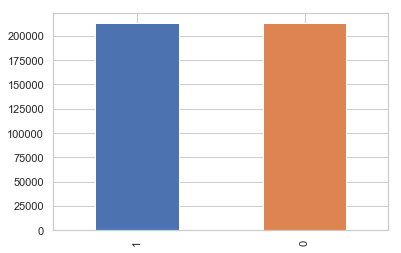

In [48]:
# observe that data has been balanced
pd.Series(y_train_smote).value_counts().plot.bar()

## SMOTE and KNN